## Data 620 - Week 3 Assignment

Baron Curtin, Heather Geiger

In [1]:
# load libraries
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# load and parse facebook data
fb_path = Path('./facebook')
edges_files = {str(f.stem): f for f in fb_path.rglob('*edges')}
circles_files = {str(f.stem): f for f in fb_path.rglob('*circles')}

In [3]:
# create empty graph
g = nx.Graph()

In [4]:
# create function to parse information from files (DRY)
def parse_file_info(my_file, node, file_type=''):
    # ensure type is passed so function can appropriately process
    if (file_type == '') | (node == ''):
        raise ValueError('Please fill in a valid file type')
    
    # use file type argument to correctly process information    
    with open(my_file, 'r') as f:
        content = f.read()
        lines = content.split('\n')
        
        # proper parsing based on file type
        if file_type == 'edges':
            without_main_node = [tuple(int(d) for d in l.split(' ')) 
                                 for l in lines
                                 if l != '']
            with_main_node = [tuple((int(node), int(x))) 
                              for l in lines
                              for x in l.split(' ')
                              if l != '']
            info = [*with_main_node, *without_main_node]
        elif file_type == 'circles':
            info = [(int(node), int(n))
                    for l in lines
                    for n in l.split('\t')[1:]
                    if l != '']
        return info
    
edges = {node: parse_file_info(edge_file, node, 'edges') 
         for node, edge_file in edges_files.items()}
circles = {node: parse_file_info(circle_file, node, 'circles') 
         for node, circle_file in circles_files.items()}

## Graph Creation

In [5]:
# begin adding nodes/edges to graph

# use node 0
g.add_edges_from(edges['0'])
g.add_edges_from(circles['0'])

<Figure size 1440x1440 with 0 Axes>

/Users/baron.curtin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-0.9486736193057779, 1.096378057239315, -1.038581887809982, 1.072308935510308)

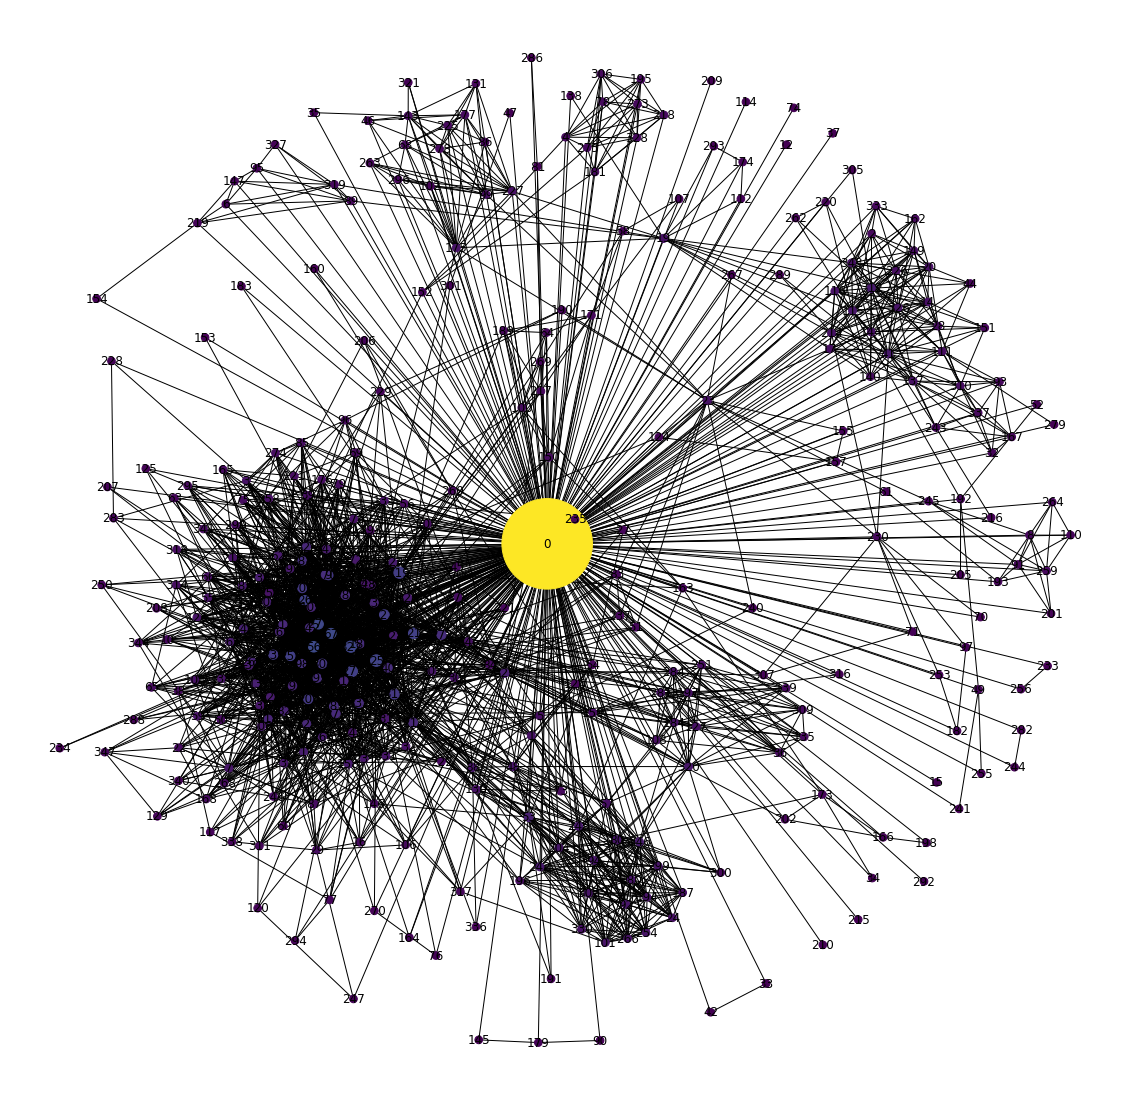

In [6]:
# make plot area larger and draw graph
# color nodes by importance
pos = nx.spring_layout(g)
bet_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 10000 for v in bet_centrality.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

## Network Analysis

In [7]:
# basic network information
print(nx.info(g))


Name: 
Type: Graph
Number of nodes: 343
Number of edges: 2861
Average degree:  16.6822


We will use the Betweenness Centrality and the Eigenvector Centrality to determine the most important nodes in our network.



In [8]:
# get a table of the top 5 values of betweenness_centrality
# also bring in eigenvector_centrality
bet_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)
eig_centrality = nx.eigenvector_centrality(g)

metrics_table = pd.DataFrame({
    'nodes': list(bet_centrality.keys()),
    'between_centrality': list(bet_centrality.values()),
    'eigenvector_centrality': list(eig_centrality.values())
})
metrics_table.sort_values('between_centrality', ascending=False)[:5]

,nodes,between_centrality,eigenvector_centrality
0,0,0.819703,0.288949
121,25,0.013318,0.144590
30,322,0.012744,0.149642
51,119,0.012557,0.127819
63,277,0.011288,0.149958


From the table below, we can see that 0 has the highest "between centrality". This makes sense as the data is derived from the perspective of node 0. Rounding out the top 5 are 121, 30, 51, and 63.

### Find the "longest shortest path" between two nodes

In [9]:
nodes = g.nodes()
paths = []

# initialize variables for shortest path
longest_shortest_path = None
longest_shortest_path_length = -1
# loop through nodes to find shortest distance
for x in nodes:
    for y in nodes:
        path_ = nx.shortest_path(g, x, y)
        path_length = nx.shortest_path_length(g, x, y)
        
        # add path and path length to dictionary
        paths.append((path_, path_length))
        
        # replace shortest_path with m if m > shortest_path
        if path_length > longest_shortest_path_length:
            longest_shortest_path = path_
            longest_shortest_path_length = path_length
            
# pass list of tuples of paths to dataframe and filter for longest_shortest_path_length
paths_df = pd.DataFrame(paths, columns=['path', 'length'])
paths_df[paths_df['length'] == longest_shortest_path_length]

,path,length
347,"[236, 0, 285]",2
348,"[236, 0, 24]",2
349,"[236, 0, 346]",2
352,"[236, 0, 176]",2
353,"[236, 0, 9]",2
...,...,...
117643,"[12, 0, 292]",2
117644,"[12, 0, 114]",2
117645,"[12, 0, 15]",2
117646,"[12, 0, 37]",2


There are 111,584 observations where the "longest shortest path length" is 2.


In [10]:
pd.concat([paths_df['length'].value_counts(), paths_df['length'].value_counts(normalize=True)], axis=1)

,length,length
2,111584,0.948448
1,5722,0.048636
0,343,0.002915


The above table summaries the lengths and their counts. We can see that ~95% of the observations are of length 2.

### Youtube Link
[Data 620 - Week 3 HW](https://youtu.be/hjseVmEVoK0)